In [1]:
!pip install SimpleITK
import SimpleITK as sitk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 9.9 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

class Double3DConvVBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bottleneck=False, befBottleneck=False) -> None:
        super(Double3DConvVBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels//2, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(num_features=out_channels//2),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_channels=out_channels//2, out_channels=out_channels, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU(inplace=True),
        )
        self.bottleneck = bottleneck
        if not bottleneck:
            self.pooling = nn.MaxPool3d(kernel_size=(2,2,2), stride=2) if not befBottleneck else nn.MaxPool3d(kernel_size=(2,2,1), stride=(2,2,1))

    def forward(self, x):
        res = self.conv(x)
        out = res
        if not self.bottleneck:
            out = self.pooling(res)
        return out, res

class UpConv3DBlock(nn.Module):
    def __init__(self, in_channels, res_channels=0, last_layer=False, num_classes=None) -> None:
        super(UpConv3DBlock, self).__init__()
        assert (last_layer == False and num_classes == None) or (last_layer == True and num_classes != None), 'Invalid arguments'
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels=in_channels + res_channels, out_channels=in_channels // 2, kernel_size=(3,3,3), padding=(1,1,1)),
            nn.BatchNorm3d(num_features=in_channels // 2),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_channels=in_channels // 2, out_channels=in_channels // 2, kernel_size=(3,3,3), padding=(1,1,1)),
            nn.BatchNorm3d(num_features=in_channels // 2),
            nn.ReLU(inplace=True),
        )
        self.last_layer = last_layer
        if last_layer:
            self.conv3 = nn.Conv3d(in_channels=in_channels // 2, out_channels=num_classes, kernel_size=(1,1,1))

    def forward(self, x, residual=None):
        if residual is not None:
            # Upsample to match the residual's spatial dimensions
            x = F.interpolate(x, size=residual.shape[2:], mode='trilinear', align_corners=False)
            x = torch.cat((x, residual), 1)
        else:
            # For the final layer, we only upsample
            x = F.interpolate(x, scale_factor=(2, 2, 1) if self.last_layer else (2, 2, 2), mode='trilinear', align_corners=False)

        x = self.conv(x)
        if self.last_layer:
            x = self.conv3(x)
        return x

class UNET3D(nn.Module):
    def __init__(self, in_channels, num_classes, level_channels=[32, 64, 128, 256], bottleneck_channel=512) -> None:
        super(UNET3D, self).__init__()
        level_1_chnls, level_2_chnls, level_3_chnls, level_4_chnls = level_channels[0], level_channels[1], level_channels[2], level_channels[3]
        self.a_block1 = Double3DConvVBlock(in_channels=in_channels, out_channels=level_1_chnls)
        self.a_block2 = Double3DConvVBlock(in_channels=level_1_chnls, out_channels=level_2_chnls)
        self.a_block3 = Double3DConvVBlock(in_channels=level_2_chnls, out_channels=level_3_chnls)
        self.a_block4 = Double3DConvVBlock(in_channels=level_3_chnls, out_channels=level_4_chnls)
        self.bottleNeck = Double3DConvVBlock(in_channels=level_4_chnls, out_channels=bottleneck_channel, bottleneck=True)
        self.s_block4 = UpConv3DBlock(in_channels=bottleneck_channel, res_channels=level_4_chnls)
        self.s_block3 = UpConv3DBlock(in_channels=level_4_chnls, res_channels=level_3_chnls)
        self.s_block2 = UpConv3DBlock(in_channels=level_3_chnls, res_channels=level_2_chnls)
        self.s_block1 = UpConv3DBlock(in_channels=level_2_chnls, res_channels=level_1_chnls, last_layer=True, num_classes=num_classes)

    def pad_input(self, x):
        # Pad the input tensor to ensure even dimensions for depth
        d_padding = (x.shape[2] % 2, 0) # pad only if the depth is odd
        return F.pad(x, d_padding + (0, 0) + (0, 0)) # pad depth, height, width

    def forward(self, input):
        input = self.pad_input(input)

        # Analysis path forward feed
        out, residual_level1 = self.a_block1(input)
        out, residual_level2 = self.a_block2(out)
        out, residual_level3 = self.a_block3(out)
        out, residual_level4 = self.a_block4(out)
        out, _ = self.bottleNeck(out)

        # Synthesis path forward feed
        out = self.s_block4(out, residual_level4)
        out = self.s_block3(out, residual_level3)
        out = self.s_block2(out, residual_level2)
        out = self.s_block1(out, residual_level1)

        # Apply softmax to output if the model is in eval mode
        if not self.training:
            out = F.softmax(out, dim=1)
        return out


In [4]:
from torchsummary import summary
def prepare_input(input):
    return input
# Configurations according to the Xenopus kidney dataset
model = UNET3D(in_channels=1, num_classes=4)

if torch.cuda.is_available():
  model = model.cuda()  # Move model to GPU if available

start_time = time.time()

# Create a dummy input with same device as model
dummy_input = prepare_input(torch.randn(2, 1, 128, 128, 44))  # Move to GPU if available

# Print the summary of the model
summary(model, input_size=(1, 128, 128, 44))

print("--- %s seconds ---" % (time.time() - start_time))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 16, 128, 128, 44]             448
       BatchNorm3d-2     [-1, 16, 128, 128, 44]              32
              ReLU-3     [-1, 16, 128, 128, 44]               0
            Conv3d-4     [-1, 32, 128, 128, 44]          13,856
       BatchNorm3d-5     [-1, 32, 128, 128, 44]              64
              ReLU-6     [-1, 32, 128, 128, 44]               0
         MaxPool3d-7       [-1, 32, 64, 64, 22]               0
Double3DConvVBlock-8  [[-1, 32, 64, 64, 22], [-1, 32, 128, 128, 44]]               0
            Conv3d-9       [-1, 32, 64, 64, 22]          27,680
      BatchNorm3d-10       [-1, 32, 64, 64, 22]              64
             ReLU-11       [-1, 32, 64, 64, 22]               0
           Conv3d-12       [-1, 64, 64, 64, 22]          55,360
      BatchNorm3d-13       [-1, 64, 64, 64, 22]             128
             ReLU-

In [5]:
import copy
import nibabel as nib
import numpy as np
import os
import tarfile
import json
from sklearn.utils import shuffle
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import random_split
import zipfile
from google.colab import drive

#Utility function to extract .tar file formats into ./Datasets directory
import os
import gzip
import shutil

drive.mount('/content/drive/',force_remount=True)
zip_dir = '/content/drive/MyDrive/MBAS_Dataset.zip'

with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
    zip_ref.extractall('MBAS_Dataset')



Mounted at /content/drive/


In [6]:
!pip install glob2
import glob2

In [7]:
import torch
from torchvision import transforms
from torchvision.transforms import functional as F
from torchvision import transforms
from scipy.ndimage import zoom

rootDir = '/content/MBAS_Dataset'

class Normalization:
  def __call__(self,image):
        """
        Normalize an image to 0 - 255 (8bits)
        """
        normalizeFilter = sitk.NormalizeImageFilter()
        resacleFilter = sitk.RescaleIntensityImageFilter()
        resacleFilter.SetOutputMaximum(255)
        resacleFilter.SetOutputMinimum(0)

        image = normalizeFilter.Execute(image)  # set mean and std deviation
        image = resacleFilter.Execute(image)  # set intensity 0-255
        return image

class ToNumpy(object):
    def __call__(self, image):
          # cast image and label to float32
          castImageFilter = sitk.CastImageFilter()
          castImageFilter.SetOutputPixelType(sitk.sitkFloat32)
          image = castImageFilter.Execute(image)
          image_array = sitk.GetArrayFromImage(image)
          return image_array

class Permute(object):
  # to unify matrix dimension order between SimpleITK([x,y,z]) and numpy([z,y,x])  (actually it´s the contrary)
  def __call__(self, image):
    #print(f"Permute INPUT: {type(image)}, {image.shape}")
    if isinstance(image, np.ndarray):
        image = np.transpose(image, (2, 1, 0))
        image = np.expand_dims(image, axis=0)
        image = torch.from_numpy(image)
        #print(f'Permute OUTPUT: {image.shape}')
        return image
    elif torch.is_tensor(image):
        image = image.permute(2, 1, 0)
        image = image.unsqueeze(0)
        #print(f'Permute OUTPUT: {image.shape}')
        return image

class MaskToTensor(object):
    def __call__(self, image):
        # cast image and label to float32
        castImageFilter = sitk.CastImageFilter()
        castImageFilter.SetOutputPixelType(sitk.sitkFloat32)
        image = castImageFilter.Execute(image)

        image_array = sitk.GetArrayFromImage(image)

        # to unify matrix dimension order between SimpleITK([x,y,z]) and numpy([z,y,x])  (actually it´s the contrary)
        image_np = np.transpose(image_array, (2, 1, 0))
        return torch.from_numpy(image_np)

class ResizeTransform:
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, img):
        #print(f"RESIZE: {img.shape}")
        # Calculate the scaling factors for each dimension
        if img.shape[1] > 64:
          d_scale = self.output_size[0] / img.shape[0]
          h_scale = self.output_size[1] / img.shape[1]
          w_scale = self.output_size[2] / img.shape[2]

          # Resize the image using nearest-neighbor interpolation
          resized = zoom(img, (d_scale, h_scale, w_scale), order=0) if isinstance(img, np.ndarray) else zoom(img.numpy(), (d_scale, h_scale, w_scale), order=0)   # order=0 for nearest-neighbor

          # Convert back to tensor
          resized = torch.from_numpy(resized)
          #print(f"RESIZED: {resized.shape}")

          #print(f"MASK RESIZE OUTPUT: {resized.shape}")
          return resized
        else:
          #print(f"MASK RESIZE OUTPUT: {img.shape}")
          return img

class ToTensor(object):
    def __call__(self, image):
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image)
            return image
        return image



In [8]:
import numpy as np
from scipy.ndimage import affine_transform, zoom
from skimage.util import random_noise
from skimage.transform import rotate, rescale
from scipy.ndimage import gaussian_filter, map_coordinates
import random


class PatchExtraction:
  def __init__(self, output_size, max_offset=None):
    self.output_size = output_size
    self.max_offset = max_offset if max_offset is not None else output_size[0] // 2  # Default offset is half the output size

  def __call__(self, sample):
    image, mask = sample['image'], sample['mask']
    if random.random() < .86 :
        # Get image and mask dimensions
        image_shape = image.shape

        # Calculate center coordinates (avoiding floor division by 2 for odd sizes)
        center_x = image_shape[1] // 2
        center_y = image_shape[2] // 2

        # Adjust max offset based on image dimensions (ensure it doesn't exceed image boundaries)
        max_offset_x = min(self.max_offset, center_x, image_shape[1] - center_x - self.output_size[1])
        max_offset_y = min(self.max_offset, center_y, image_shape[2] - center_y - self.output_size[2])

        # Generate random offsets within limits
        offset_x = random.randint(-max_offset_x, max_offset_x)
        offset_y = random.randint(-max_offset_y, max_offset_y)

        # Calculate starting and ending indices
        start_x = center_x + offset_x
        start_y = center_y + offset_y
        end_x = start_x + self.output_size[1]
        end_y = start_y + self.output_size[2]

        # Handle edge cases (ensure indices stay within image boundaries)
        start_x = max(0, start_x)  # Clip start_x to 0 (minimum)
        end_x = min(image_shape[1], end_x)  # Clip end_x to image width
        start_y = max(0, start_y)  # Clip start_y to 0 (minimum)
        end_y = min(image_shape[2], end_y)  # Clip end_y to image depth

        # Extract the patch
        image = image[:, start_x:end_x, start_y:end_y]
        mask = mask[:, start_x:end_x, start_y:end_y] if mask is not None else mask

        # You can uncomment the print statement for debugging purposes
        print(f"PATCH EXTRACTION: TOOK {start_x, end_x, start_y, end_y}")

        return {'image': image, 'mask': mask}
    else:
        # Calculate the maximum starting indices for x, y, z
        max_z = image.shape[0] - self.output_size[0]
        max_x = image.shape[1] - self.output_size[1]
        max_y = image.shape[2] - self.output_size[2]

        # Randomly select the starting indices
        start_x = np.random.randint(0, max_x) if max_x > 0 else 0
        start_y = np.random.randint(0, max_y) if max_y > 0 else 0
        start_z = np.random.randint(0, max_z) if max_z > 0 else 0

        # Calculate the ending indices
        end_z = start_z + self.output_size[0]
        end_x = start_x + self.output_size[1]
        end_y = start_y + self.output_size[2]

        # Extract the patch
        image = image[start_z:end_z, start_x:end_x, start_y:end_y]
        mask = mask[start_z:end_z, start_x:end_x, start_y:end_y] if mask is not None else mask
        print(f"PATCH EXTRACTION: TOOK {start_z, end_z, start_x, end_x, start_y, end_y}")
        return {'image': image, 'mask': mask}

class RandomFlip:
    def __init__(self, probability):
        self.probability = probability
        self.random_state = np.random.RandomState()

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        if self.random_state.rand() < self.probability:
            axes = [i for i in range(image.ndim)]
            flip_axis = self.random_state.choice(axes)
            image = np.flip(image, axis=flip_axis).copy()  # Make a copy after flipping
            mask = np.flip(mask, axis=flip_axis).copy()  # Make a copy after flipping
            #print(f"RANDOMFLIP: flipped using {flip_axis} axes")
        return {'image': image, 'mask': mask}


class RandomRotation:
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        angle = np.random.choice(self.angles)
        image = rotate(image, angle, mode='reflect')
        mask = rotate(mask, angle, mode='reflect') if mask is not None else mask
        #print(f"RANDOM ROTATION: rotated to angle {angle} ")
        return {'image': image, 'mask': mask}

class RandomScale:
    def __init__(self, scale_range, output_shape):
        self.scale_range = scale_range
        self.output_shape = output_shape

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        scale = np.random.uniform(*self.scale_range)

        # Scale the image and mask
        image = rescale(image, scale)
        mask = rescale(mask, scale) if mask is not None else mask

        # Resize the image and mask back to the original size
        image = rescale(image, self.output_shape / np.array(image.shape))
        mask = rescale(mask, self.output_shape / np.array(mask.shape)) if mask is not None else mask

        #print(f"RANDOM SCALE: scaled to {self.scale_range}")
        return {'image': image, 'mask': mask}

class RandomBrightness:
    def __init__(self, range):
        self.range = range

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        g = np.random.uniform(*self.range)
        gamma = np.random.uniform(*self.range)
        image = g * np.power(image, gamma)
        #print(f"RandomBrightness: {g, gamma, image}")
        return {'image': image, 'mask': mask}

class ElasticDeformation:
    def __init__(self, sigma):
        self.sigma = sigma

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        sigma = np.random.choice(self.sigma)
        dx = gaussian_filter((np.random.rand(*image.shape) * 2 - 1), sigma, mode="constant", cval=0) * sigma
        dy = gaussian_filter((np.random.rand(*image.shape) * 2 - 1), sigma, mode="constant", cval=0) * sigma
        dz = gaussian_filter((np.random.rand(*image.shape) * 2 - 1), sigma, mode="constant", cval=0) * sigma
        x, y, z = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]), np.arange(image.shape[2]), indexing='ij')
        indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1)), np.reshape(z+dz, (-1, 1))
        distored_image = map_coordinates(image, indices, order=1, mode='reflect')
        if mask is not None:
            distored_mask = map_coordinates(mask, indices, order=1, mode='reflect')
            return {'image': torch.from_numpy(distored_image.reshape(image.shape)), 'mask': torch.from_numpy(distored_mask.reshape(mask.shape))}
        return {'image': torch.from_numpy(distored_image.reshape(image.shape)), 'mask': None}



In [9]:
import SimpleITK as sitk
import numpy as np
import os

def find_unique_classes(masks):
    unique_classes = set()
    for mask_file in masks:
        mask = sitk.ReadImage(mask_file)
        mask = sitk.GetArrayFromImage(mask)
        unique_classes.update(np.unique(mask))
        if len(np.unique(mask)) > 4:
          print('Error')
    return unique_classes

rootDir = '/content/MBAS_Dataset'

mask_dir = glob2.glob(rootDir  + '/Training' + '/**/*label*.nii.gz')
unique_classes = find_unique_classes(mask_dir)
print(f'The unique classes in the masks are: {unique_classes}')


The unique classes in the masks are: {0, 1, 2, 3}


In [10]:
'''
class Loader(Dataset):
    def __init__(self, dir_path, transforms = None, mode = None) -> None:
        super(Loader, self).__init__()
    def __len__(self):
      pass
    def __getitem__(self,idx):
      pass
    def set_mode(self, mode):
      self.mode = mode
'''
import os

class MyDataset(Dataset):
    def __init__(self, root_dir, mode='Training', transform=None):
        print(mode)
        f_path = "Validation" if mode == "Testing" else ("Training" if mode == "Validation" else mode)
        self.image_paths = [f for f in (glob2.glob(root_dir + f'/{f_path}' + '/**/*.nii.gz')) if 'label' not in f]
        self.image_filenames = [path.split('/')[-1].split('.')[0] for path in self.image_paths]
        self.image_paths.sort()
        self.image_filenames.sort()

        if mode != 'Testing':
          self.mask_paths = glob2.glob(root_dir  + f'/{f_path}' + '/**/*label*.nii.gz')
          self.mask_filenames = [path.split('/')[-1].split('.')[0] for path in self.mask_paths]
          self.mask_paths.sort()
          self.mask_filenames.sort()

        self.common_transform = transform[0]
        self.image_transform = transform[1]
        self.mask_transform = transform[2]
        self.mode = mode

    def set_mode(self, mode):
        self.mode = mode

    def __len__(self):
        return len(self.image_paths)

    def read_image(self, path):
          reader = sitk.ImageFileReader()
          reader.SetFileName(path)
          image = reader.Execute()
          return image

    def castItem(self, image, desired_orientation='RPS'):
      # Apply the desired orientation
      image = sitk.DICOMOrient(image, desired_orientation)

      castImageFilter = sitk.CastImageFilter()
      castImageFilter.SetOutputPixelType(sitk.sitkFloat32)
      image = castImageFilter.Execute(image)
      image_array = sitk.GetArrayFromImage(image)
      if desired_orientation == 'LIA': #the LIA orientation shows [height, depth, width]
        image_array = np.transpose(image_array, (1, 0, 2))
      return image_array

    def __getitem__(self, idx):
        image = self.read_image(self.image_paths[idx])
        orientation = random.choices(["RPS", "LIA", "LPS"], weights=[.76, .12, .12])[0]
        image = self.castItem(image, orientation)

        if self.mode != 'Testing':
          mask = self.read_image(self.mask_paths[idx])
          mask = self.castItem(mask, orientation)
          sample = {'image': image, 'mask': mask}
          if self.mode == "Training":
              # Apply the transformations
              sample = self.common_transform(sample)
              image = sample['image']
              mask = sample['mask']
          image = self.image_transform(image)
          mask = self.mask_transform(mask)
          # Apply one_hot_encode to the mask
          mask = self.one_hot_encode(mask)
          return image, mask

        else:  # If mode is 'test'
          # Create a dictionary with the image and a dummy mask
          sample = {'image': image, 'mask': None}

          # Apply the transformations only to the image
          transformed_images = self.image_transform(sample['image'])
          return transformed_images

    def one_hot_encode(self, mask):
        # Convert mask to integer type before one-hot encoding
        mask_tensor = mask.long()
        encoded_mask = torch.nn.functional.one_hot(mask_tensor)

        if encoded_mask.dim() == 5:  # Check for 5 dimensions
            encoded_mask = encoded_mask.squeeze(0)  # Remove batch dimension if present
        encoded_mask = encoded_mask.permute(3, 1, 2, 0)  # [num_channels, width, height, depth] from [depth, width, height]

        # Check if any channels are missing
        for i in range(4):
            if i not in mask_tensor.unique():
                # Create a tensor of zeros for the missing channel
                zeros = torch.zeros((1, encoded_mask.shape[1], encoded_mask.shape[2], encoded_mask.shape[3]), dtype=encoded_mask.dtype, device=encoded_mask.device)
                # Insert the zeros tensor at the correct index
                encoded_mask = torch.cat([encoded_mask[:i], zeros, encoded_mask[i:]], dim=0)
        return encoded_mask


'\n    def one_hot_encode(self, mask):\n      #print(f"INPUT ONE-HOT-ENCODING: {mask.shape}, {type(mask)}")\n      # Convert mask to integer type before one-hot encoding\n      mask_tensor = mask.long()\n      encoded_mask = torch.nn.functional.one_hot(mask_tensor)\n      if encoded_mask.dim() == 5:  # Check for 5 dimensions\n          encoded_mask = encoded_mask.squeeze(0)  # Remove batch dimension if present\n      #print(f"OUTPUT ONE-HOT-ENCODING: {encoded_mask.shape}")\n      encoded_mask = encoded_mask.permute(3, 1, 2, 0)  # [num_channels, width, height, depth] from [depth, width, height]\n      #print(f"RESHAPED OUTPUT ONE-HOT-ENCODING: {encoded_mask.shape}")\n\n      return encoded_mask\n'

In [11]:
def plot_slice(input_image, mask_image, output_image):
    # Number of channels for mask and output images
    num_channels = mask_image.shape[1]

    # Create a new figure for input
    fig, ax = plt.subplots(figsize=(6, 6))

    # Select the middle slice of the input image
    input_slice = input_image[0, 0, :, :, 21].squeeze(0)

    # Plot the slice
    ax.imshow(input_slice.cpu().numpy(), cmap='gray')
    ax.set_title('Input Image')

    # Display the figure
    plt.show()

    # Create a new figure for mask and output
    fig, axes = plt.subplots(num_channels, 2, figsize=(12, 6 * num_channels))
    axes = np.atleast_2d(axes)  # Ensure axes is a 2D array

    for i in range(num_channels):
        # Select the middle slice of a specific channel
        mask_slice = mask_image[0, i, :, :, 21].squeeze(0)
        output_slice = output_image[0, i, :, :, 21].detach().squeeze(0)

        # Plot the slices
        axes[i, 0].imshow(mask_slice.cpu().numpy(), cmap='gray')
        axes[i, 0].set_title(f'Mask Image - Channel {i}')

        axes[i, 1].imshow(output_slice.cpu().numpy(), cmap='gray')
        axes[i, 1].set_title(f'Output Image - Channel {i}')

    # Display the figure
    plt.show()



In [12]:
def dice_loss(inputs, target, num_classes, smooth=1e-5):
    inputs = torch.softmax(inputs, dim=1)  # Apply softmax to the inputs

    intersection = (inputs * target).sum(dim=(2, 3, 4))  # Compute the intersection
    union = inputs.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))  # Compute the union

    dice_scores = (2 * intersection + smooth) / (union + smooth)  # Compute the Dice scores for each class
    return 1 - dice_scores.mean()  # Return the mean Dice loss



In [13]:
import matplotlib.pyplot as plt

from ipywidgets import interact
import numpy as np
import SimpleITK as sitk
import cv2

def explore_3D_array(arr: np.ndarray, cmap: str = 'gray'):
  """
  Given a 3D array with shape (Z,X,Y) This function will create an interactive
  widget to check out all the 2D arrays with shape (X,Y) inside the 3D array.
  The purpose of this function to visual inspect the 2D arrays in the image.

  Args:
    arr : 3D array with shape (Z,X,Y) that represents the volume of a MRI image
    cmap : Which color map use to plot the slices in matplotlib.pyplot
  """
  def fn(SLICE):
    plt.figure(figsize=(7,7))
    plt.imshow(arr[SLICE, :, :], cmap=cmap)

  interact(fn, SLICE=(0, arr.shape[0]-1))


def explore_3D_array_comparison(arr_before: np.ndarray, arr_after: np.ndarray, cmap: str = 'gray'):
  """
  Given two 3D arrays with shape (Z,X,Y) This function will create an interactive
  widget to check out all the 2D arrays with shape (X,Y) inside the 3D arrays.
  The purpose of this function to visual compare the 2D arrays after some transformation.

  Args:
    arr_before : 3D array with shape (Z,X,Y) that represents the volume of a MRI image, before any transform
    arr_after : 3D array with shape (Z,X,Y) that represents the volume of a MRI image, after some transform
    cmap : Which color map use to plot the slices in matplotlib.pyplot
  """

  assert arr_after.shape == arr_before.shape

  def fn(SLICE):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10,10))

    ax1.set_title('Before', fontsize=15)
    ax1.imshow(arr_before[SLICE, :, :], cmap=cmap)

    ax2.set_title('After', fontsize=15)
    ax2.imshow(arr_after[SLICE, :, :], cmap=cmap)

    plt.tight_layout()

  interact(fn, SLICE=(0, arr_before.shape[0]-1))


def show_sitk_img_info(img: sitk.Image):
  """
  Given a sitk.Image instance prints the information about the MRI image contained.

  Args:
    img : instance of the sitk.Image to check out
  """
  pixel_type = img.GetPixelIDTypeAsString()
  origin = img.GetOrigin()
  dimensions = img.GetSize()
  spacing = img.GetSpacing()
  direction = img.GetDirection()

  info = {'Pixel Type' : pixel_type, 'Dimensions': dimensions, 'Spacing': spacing, 'Origin': origin,  'Direction' : direction}
  for k,v in info.items():
    print(f' {k} : {v}')


def add_suffix_to_filename(filename: str, suffix:str) -> str:
  """
  Takes a NIfTI filename and appends a suffix.

  Args:
      filename : NIfTI filename
      suffix : suffix to append

  Returns:
      str : filename after append the suffix
  """
  if filename.endswith('.nii'):
      result = filename.replace('.nii', f'_{suffix}.nii')
      return result
  elif filename.endswith('.nii.gz'):
      result = filename.replace('.nii.gz', f'_{suffix}.nii.gz')
      return result
  else:
      raise RuntimeError('filename with unknown extension')


def rescale_linear(array: np.ndarray, new_min: int, new_max: int):
  """Rescale an array linearly."""
  minimum, maximum = np.min(array), np.max(array)
  m = (new_max - new_min) / (maximum - minimum)
  b = new_min - m * minimum
  return m * array + b


def explore_3D_array_with_mask_contour(arr: np.ndarray, mask: np.ndarray, thickness: int = 1):
  """
  Given a 3D array with shape (Z,X,Y) This function will create an interactive
  widget to check out all the 2D arrays with shape (X,Y) inside the 3D array. The binary
  mask provided will be used to overlay contours of the region of interest over the
  array. The purpose of this function is to visual inspect the region delimited by the mask.

  Args:
    arr : 3D array with shape (Z,X,Y) that represents the volume of a MRI image
    mask : binary mask to obtain the region of interest
  """
  assert arr.shape == mask.shape

  _arr = rescale_linear(arr,0,1)
  _mask = rescale_linear(mask,0,1)
  _mask = _mask.astype(np.uint8)

  def fn(SLICE):
    arr_rgb = cv2.cvtColor(_arr[SLICE, :, :], cv2.COLOR_GRAY2RGB)
    contours, _ = cv2.findContours(_mask[SLICE, :, :], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    arr_with_contours = cv2.drawContours(arr_rgb, contours, -1, (0,1,0), thickness)

    plt.figure(figsize=(7,7))
    plt.imshow(arr_with_contours)

  interact(fn, SLICE=(0, arr.shape[0]-1))

def explore_4D_array_comparison(arr_before: np.ndarray, arr_after: np.ndarray, cmap: str = 'gray'):
    """
    Given two 5D arrays with shape (B,C,Z,X,Y) This function will create an interactive
    widget to check out all the 2D arrays with shape (X,Y) inside the 5D arrays.
    The purpose of this function to visual compare the 2D arrays after some transformation.

    Args:
        arr_before : 5D array with shape (B,C,Z,X,Y) that represents the volume of a MRI image, before any transform
        arr_after : 5D array with shape (B,C,Z,X,Y) that represents the volume of a MRI image, after some transform
        cmap : Which color map use to plot the slices in matplotlib.pyplot
    """
    print(arr_before.shape, arr_after.shape)
    assert arr_after.shape == arr_before.shape

    def fn(BATCH, CHANNEL, SLICE):
        fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10,10))

        ax1.set_title('Before', fontsize=15)
        ax1.imshow(arr_before[BATCH, CHANNEL, :, :, SLICE], cmap=cmap)

        ax2.set_title('After', fontsize=15)
        ax2.imshow(arr_after[BATCH, CHANNEL, :, :, SLICE], cmap=cmap)

        plt.tight_layout()

    interact(fn, BATCH=(0, arr_before.shape[0]-1), CHANNEL=(0, arr_before.shape[1]-1), SLICE=(0, arr_before.shape[4]-1))


In [14]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)


In [16]:
class MyTransforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, sample):
        # Apply the image transformations
        if len(self.transforms) != 0:
          for t in self.transforms:
              print(f"INPUT: {sample['image'].shape}, {type(sample['image'])} \n mask: {sample['mask'].shape if sample['mask'] is not None else None}, {type(sample['mask']) if sample['mask'] is not None else None} for: {t}")
              sample = t(sample)
              print(f"OUTPUT: {type(sample)} composed by \n image: {sample['image'].shape}, {type(sample['image'])} \n mask: {sample['mask'].shape if sample['mask'] is not None else None}, {type(sample['mask']) if sample['mask'] is not None else None} \n for: {t}")
          image, mask = sample['image'], sample['mask']
          #print("--------------END TRANSFORMATIONS--------------")
        return sample


In [17]:
pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 12.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [18]:
import math
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, Callback


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IN_CHANNELS = 1
NUM_CLASSES = 4

# Define the Dice coefficient
def dice_coeff(pred, target):
    smooth = 1.
    pred = pred.float()
    target = target.float()
    intersection = (pred * target).sum(dim=(2, 3, 4))
    union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

'''
common_transform = [
    PatchExtraction((44, 128, 128)),
    RandomRotation([0, 90, 180, 270]),
    #RandomScale([0.8, 1.2], output_shape=(44, 128, 128)),
    ElasticDeformation([2, 5, 8, 10])
    ]
'''
common_transform = []

image_transform = transforms.Compose([ ResizeTransform((44, 64, 64)), Permute() ])
mask_transform = transforms.Compose([ ResizeTransform((44, 64, 64)), ToTensor() ])

transform = MyTransforms(common_transform)
transform_array = [transform, image_transform, mask_transform]

check_dir = '/content/drive/MyDrive/3DUnetCheckPoint'
subdirectory = "checkpoint"
save_dir = os.path.join(check_dir, f'{subdirectory}')

# Define ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath= save_dir,  # Specify checkpoint directory
    filename="model",  # Filename format with epoch number
    monitor="val_loss",  # Metric to monitor for saving best models
    mode="min",  # Save the model with the lowest monitored metric
    save_top_k=3  # Keep the top 3 best models based on the monitored metric
)

#plot_callback definition
class VisualisationSliceCallback(Callback):
    def __init__(self, slice_index=22):
        super().__init__()
        self.slice_index = slice_index

    def on_train_epoch_end(self, trainer, pl_module):
        # Get a batch of data
        #images, masks = next(iter(trainer.datamodule.train_dataloader()))
        images, masks = trainer.datamodule.train_dataset[0]
        print(images.shape, masks.shape)
        # Get the specific slices
        image_slice = images[0, :, :, self.slice_index].cpu().numpy()
        mask_slice = masks[0, :, :, self.slice_index].cpu().numpy()
        print("arrived 1")
        # Forward pass to get the model output
        with torch.no_grad():
            outputs = pl_module(images)
        output_slice = outputs[0, :, :, self.slice_index,].detach().cpu().numpy()
        print("arrived 2")
        # Plot the slices calling the relative function insiede the pl_module
        pl_module.plot_slice(image_slice, mask_slice, output_slice, trainer.current_epoch)

#plot_callback instantiation
plot_callback = VisualisationSliceCallback(slice_index=22)  # Choose your desired slice index

# Early stopping callback
early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")


In [19]:
!pip install wandb
!wandb login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [20]:
from torch.utils.data import random_split
from pytorch_lightning import LightningDataModule
from pytorch_lightning.loggers import WandbLogger

class TrainDataModule(LightningDataModule):
    def __init__(self, root_dir, transform_array, train_split=0.8, batch_size=2):
        super().__init__()
        self.root_dir = root_dir
        self.train_split = train_split
        self.batch_size = batch_size
        self.transforms = transform_array

    def setup(self, stage=None):
        # Create full dataset
        self.full_datasetTrain = MyDataset(root_dir=self.root_dir, mode='Training', transform=self.transforms)
        self.full_datasetVal = MyDataset(root_dir=self.root_dir, mode='Validation', transform=self.transforms)
        print(f"Full train dataset length: {len(self.full_datasetTrain)}")
        print(f"Full val dataset length: {len(self.full_datasetVal)}")

        # Split into training and validation datasets
        train_len = int(len(self.full_datasetTrain) * self.train_split)
        #val_len = len(self.full_datasetTrain) - train_len
        #randomly divide the dataset
        #self.train_dataset, self.val_dataset = random_split(full_dataset, [train_len, val_len])

        # Manually divide the dataset
        indices = list(range(len(self.full_datasetTrain)))
        train_indices = indices[:train_len]
        val_indices = indices[train_len:]

        self.train_dataset = torch.utils.data.Subset(self.full_datasetTrain, train_indices)
        self.val_dataset = torch.utils.data.Subset(self.full_datasetVal, val_indices)

        print(f"Train set length: {len(self.train_dataset)}")
        print(f"Validation set length: {len(self.val_dataset)}")

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)


In [22]:
!pip install py plotly


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 2.6 MB/s eta 0:00:00


In [23]:
class TestDataModule(LightningDataModule):
    def __init__(self, root_dir,transform_array, batch_size=2):
        super().__init__()
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.transforms = transform_array

    def setup(self, stage=None):
        # Create test dataset
        self.test_dataset = MyDataset(root_dir=self.root_dir, mode="Testing", transform=self.transforms)
        print(f"Test set length: {len(self.test_dataset)}")

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=1, shuffle=False)

In [24]:
class UNETModule(pl.LightningModule):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.model = UNET3D(in_channels, num_classes)
        self.criterion = CrossEntropyLoss()
        self.in_channels = in_channels
        self.num_classes = num_classes

    @classmethod
    def load_from_checkpoint(cls, checkpoint_path, **kwargs):
      #model = cls.load_from_checkpoint(checkpoint_path=checkpoint_path)  # Call Lightning's method
      model = super().load_from_checkpoint(checkpoint_path, **kwargs)
      model.to(device)  # Move the model to the appropriate device (CPU or GPU)
      return model

    def forward(self, images):
        return self.model(images)

    def training_step(self, batch, batch_idx):
        #print("(TS1)")
        #print(f"TRAIN {batch_idx}")
        images, masks = batch
        #print(f"T Images device after: {images.device}")
        outputs = self.forward(images)
        #print(f"T Outputs device : {outputs.device}")
        #masks = masks.long()  # Ensure masks are long for CrossEntropyLoss
        loss = self.criterion(outputs, masks.float())
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        #print("(TS2)")
        if (self.trainer.current_epoch == 0 and batch_idx == 13) or (self.trainer.current_epoch % 3 == 0 and batch_idx == 13):
          print("PLOTTING TRAIN")
          print(images.shape, masks.shape, outputs.shape)
          last_image = images[0, :, :, :, :]
          last_mask = masks[0, :, :, :, :]
          last_output = outputs[0, :, :, :, :]
          self.plot_slice(last_image, last_mask, last_output, self.current_epoch)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self.forward(images)
        loss = self.criterion(outputs, masks.float())
        preds = F.softmax(outputs, dim=1)

        dice_score = dice_coeff(preds, masks)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_dice", dice_score, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        if (self.trainer.current_epoch == 0 and batch_idx == 3) or (self.trainer.current_epoch % 3 == 0 and batch_idx == 3):
          print("PLOTTING VALIDATION")
          print(images.shape, masks.shape, outputs.shape)
          last_image = images[-1, :, :, :, :]
          last_mask = masks[-1, :, :, :, :]
          last_output = outputs[-1, :, :, :, :]
          self.plot_slice(last_image, last_mask, last_output, self.current_epoch)
        return {"loss": loss, "dice": dice_score}

    def test_step(self, batch, batch_idx):
        images = batch
        outputs = self.forward(images)
        preds = F.softmax(outputs, dim=1)
        if batch_idx == 28:
          print("PLOTTING TEST")
          print(images.shape, outputs.shape)
          last_image = images[-1, :, :, :, :]
          last_output = outputs[-1, :, :, :, :]
          self.plot_slice(images, None, outputs, self.current_epoch)
        return {"loss": None, "dice": None}

    def plot_slice(self, last_image, last_mask, last_output, epoch , NUM_CLASSES=4):
      # Plot the data using matplotlib
      plt.figure(figsize=(4,4))
      plt.imshow(last_image[0, :, :, 21].cpu().numpy(), cmap='gray')
      plt.title('Input Image')
      plt.show()

      if last_mask != None:
          fig, axs = plt.subplots(nrows=1, ncols=NUM_CLASSES, figsize=(15, 15))
          for i in range(NUM_CLASSES):
              axs[i].imshow(last_mask[i, :, :, 21].cpu().numpy(), cmap='gray')
              axs[i].set_title(f'Mask Channel {i}')
          plt.show()

      fig, axs = plt.subplots(nrows=1, ncols=NUM_CLASSES, figsize=(15, 15))
      for i in range(NUM_CLASSES):
          axs[i].imshow(last_output[i, :, :, 21].detach().cpu().numpy(), cmap='gray')
          axs[i].set_title(f'Output Channel {i}')
      plt.show()

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.001)


In [ ]:
log_dir = "/content/drive/MyDrive/3DUnetCheckPoint/log"  # Replace with your desired directory
#logger = TensorBoardLogger(save_dir=log_dir)
wandb_logger = WandbLogger(project="3D-UNet-LastClean",log_model="all")  # Replace with your project name (optional)

# Define data module
train_data_module = TrainDataModule(root_dir=rootDir, transform_array=transform_array, train_split=0.8, batch_size=4)
#val_data_module = ValidationDataModule(root_dir=rootDir, transform_array=transform_array, train_split=0.8, batch_size=4)
test_data_module = TestDataModule(root_dir=rootDir, transform_array=transform_array, batch_size=4)

# Define trainer
trainer = Trainer(
    max_epochs=1000,
    callbacks=[checkpoint_callback, early_stopping],
    accelerator='gpu',
    logger=wandb_logger,
    #log_every_n_steps=14
)


# Train the model
checkpoint_path = '/content/drive/MyDrive/3DUnetCheckPoint/checkpoint'  # Assuming "best" model

'''
check = glob2.glob(checkpoint_path  + '/*.ckpt')
if len(check) != 0:
    check.sort()
    UNETModule.load_from_checkpoint('/content/drive/MyDrive/3DUnetCheckPoint/checkpoint/model_withTransf-v1.ckpt', in_channels=IN_CHANNELS, num_classes=NUM_CLASSES)
else:
    model = UNETModule(in_channels=IN_CHANNELS, num_classes=NUM_CLASSES)
'''
model = UNETModule(in_channels=IN_CHANNELS, num_classes=NUM_CLASSES)

#trainer.fit(model, datamodule=train_data_module)

# Test the model (optional during training)
trainer.test(model, dataloaders=test_data_module)


torch.Size([1, 1, 64, 64, 44]) torch.Size([1, 4, 64, 64, 44])
(1, 4, 64, 64, 44) (1, 4, 64, 64, 44)


interactive(children=(IntSlider(value=0, description='BATCH', max=0), IntSlider(value=1, description='CHANNEL'…

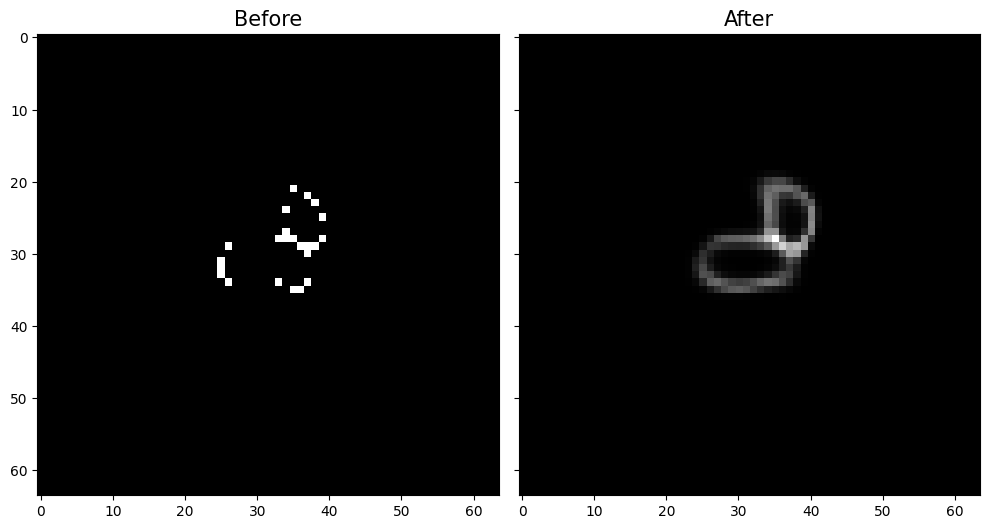

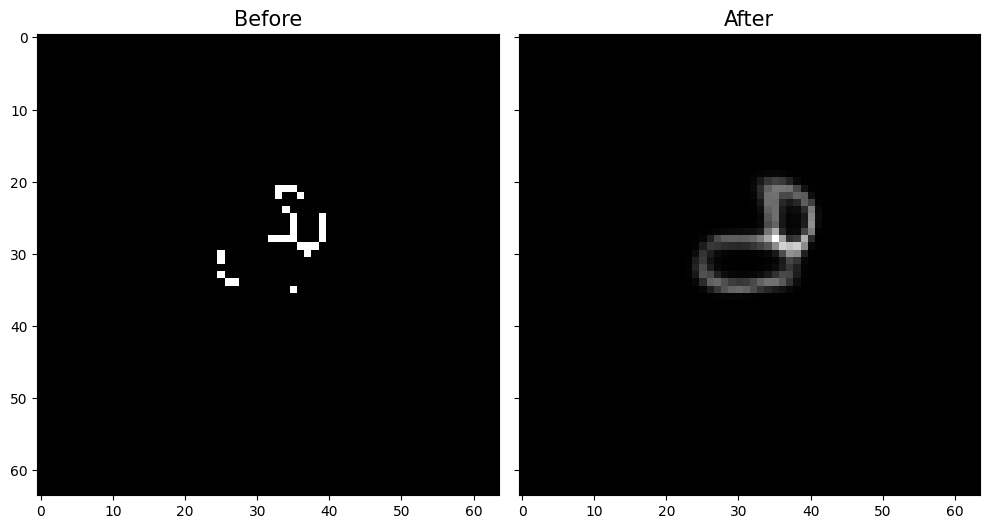

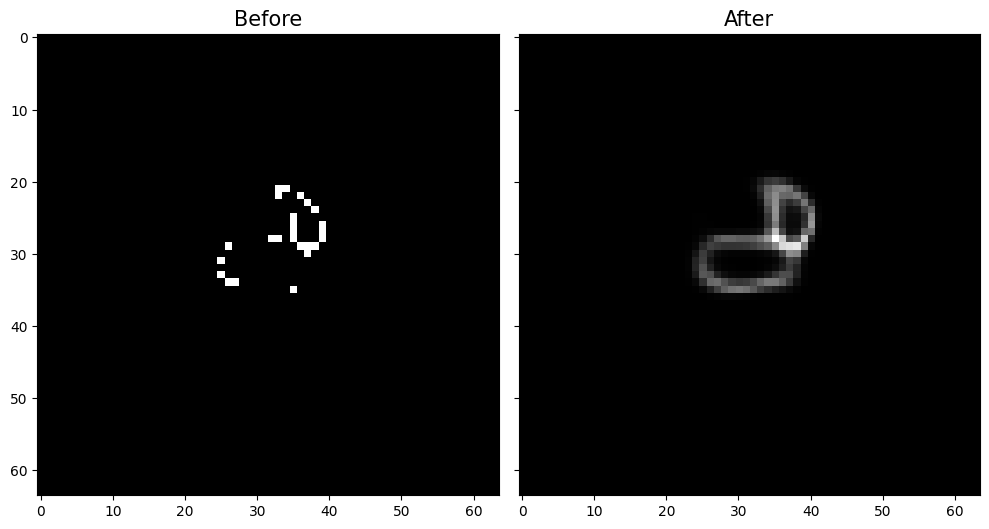

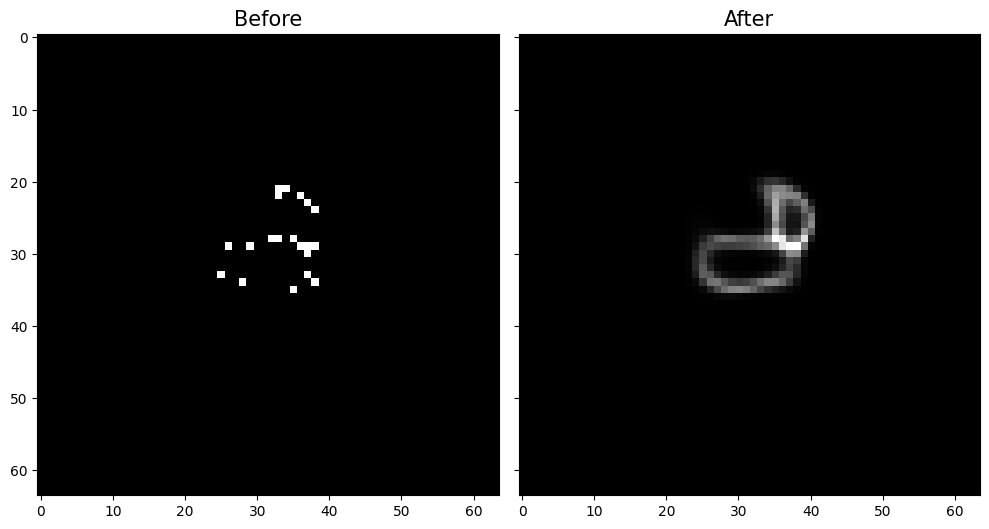

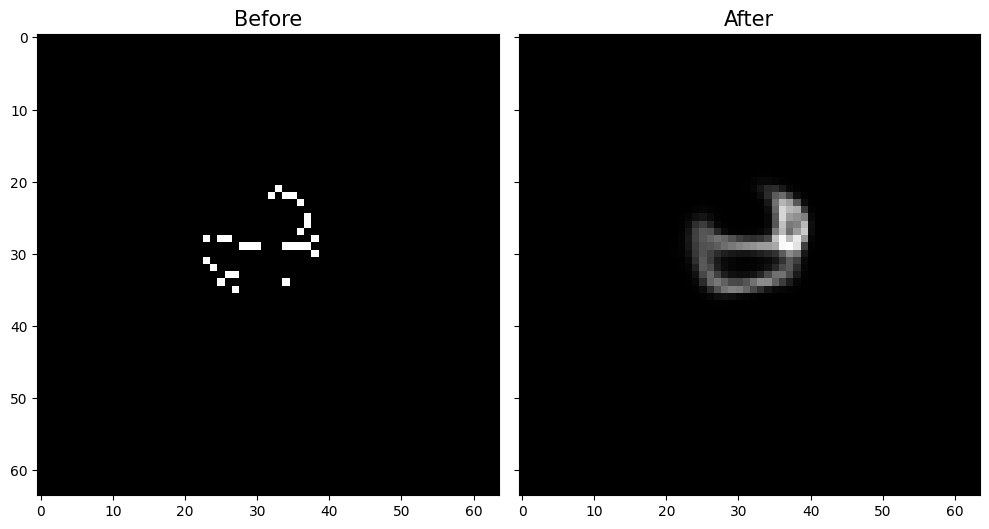

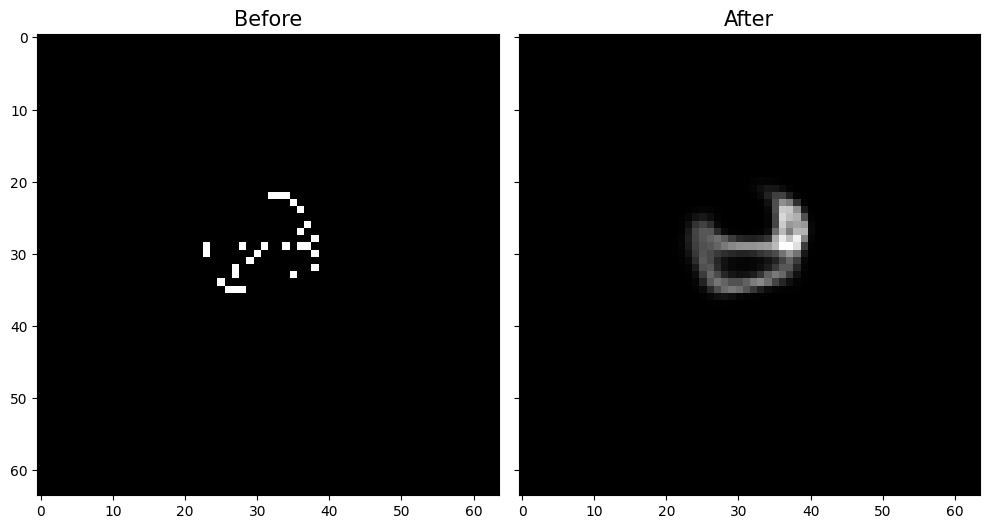

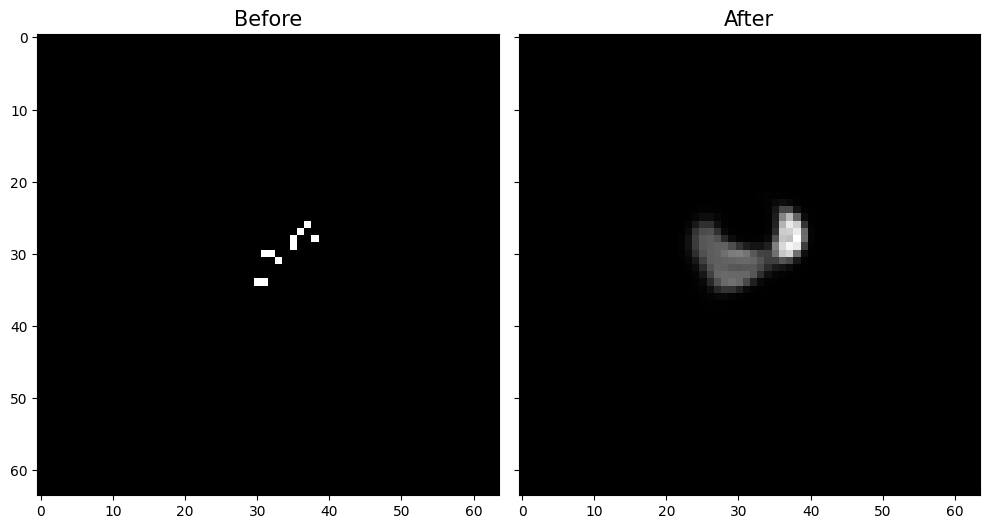

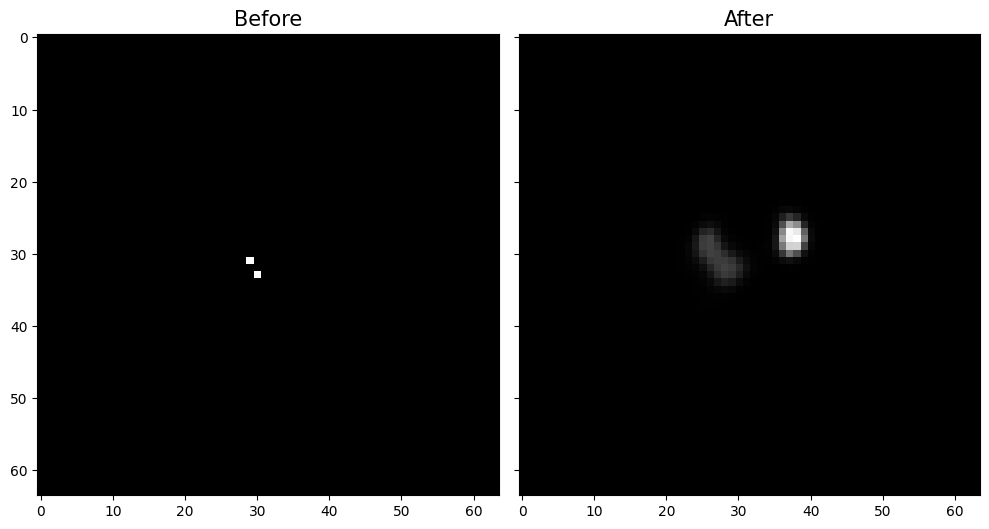

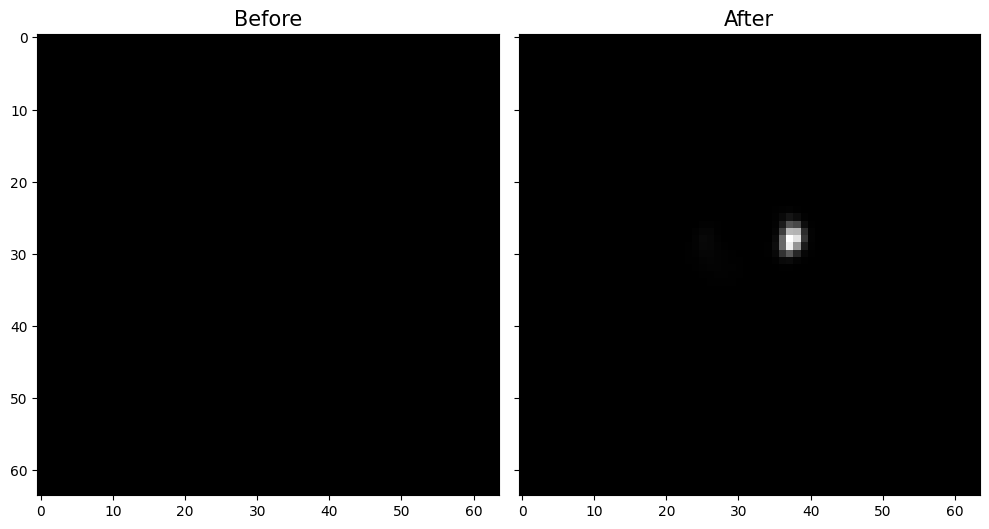

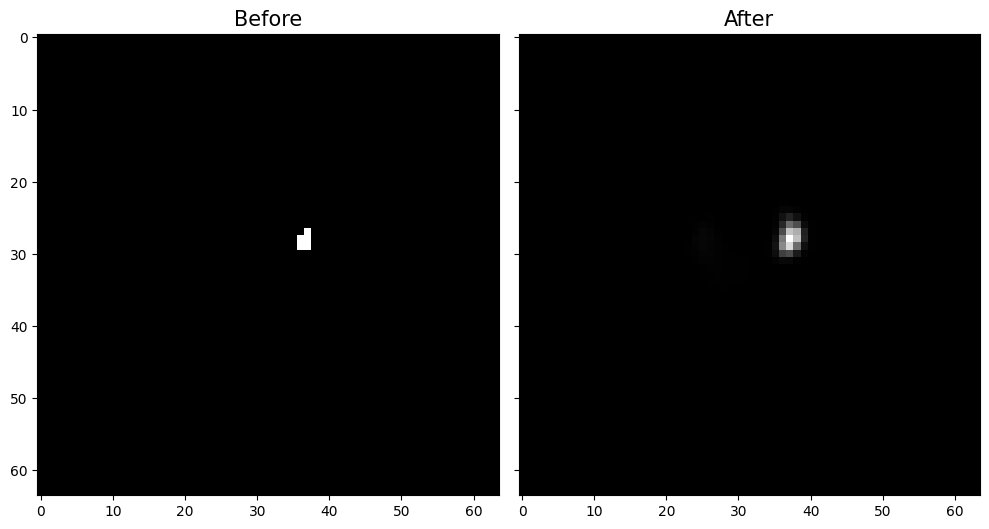

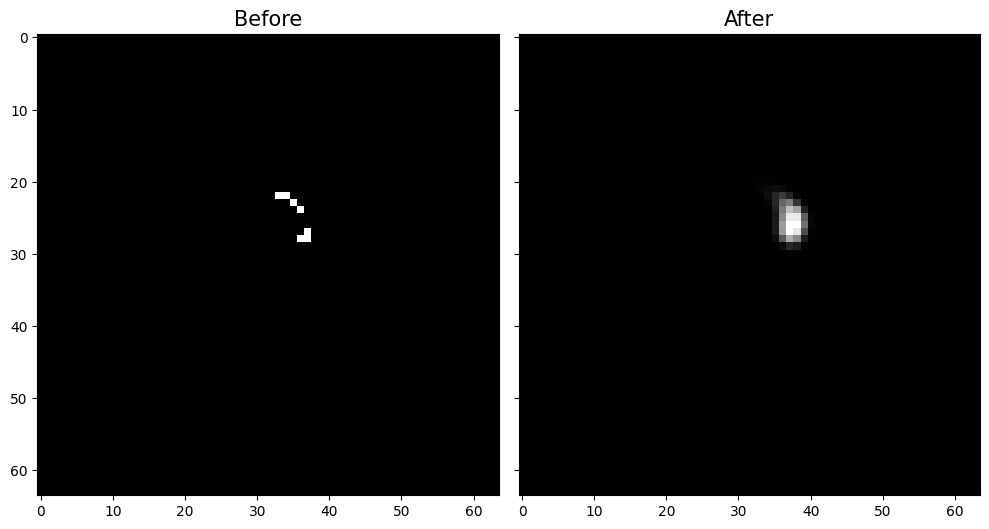

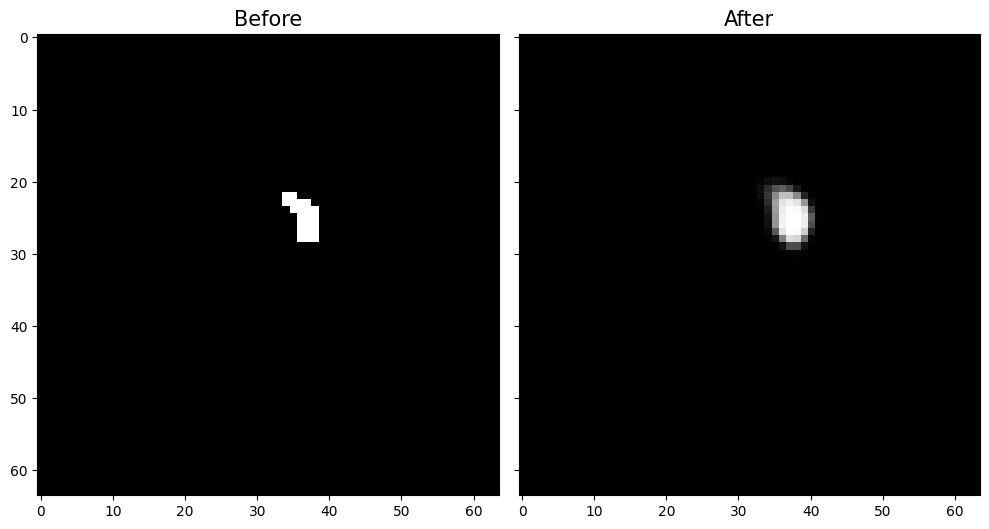

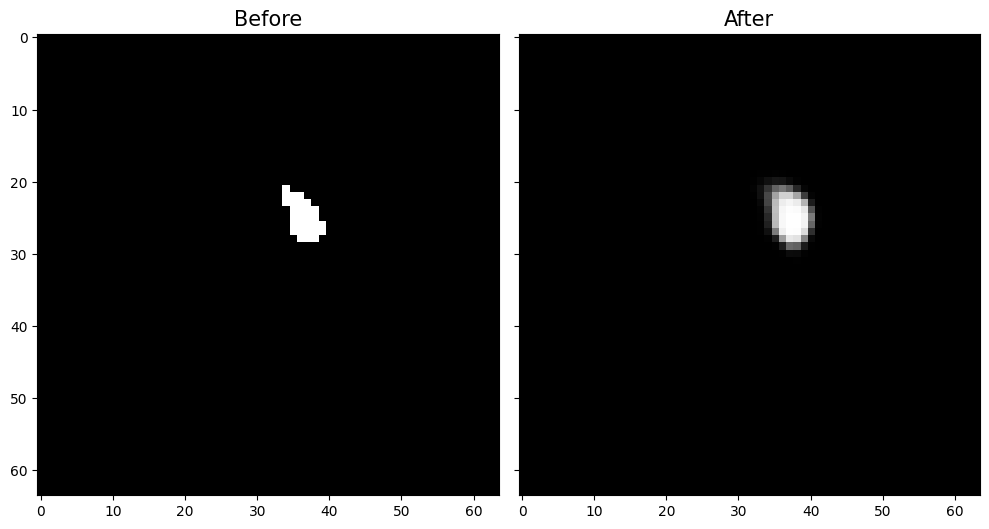

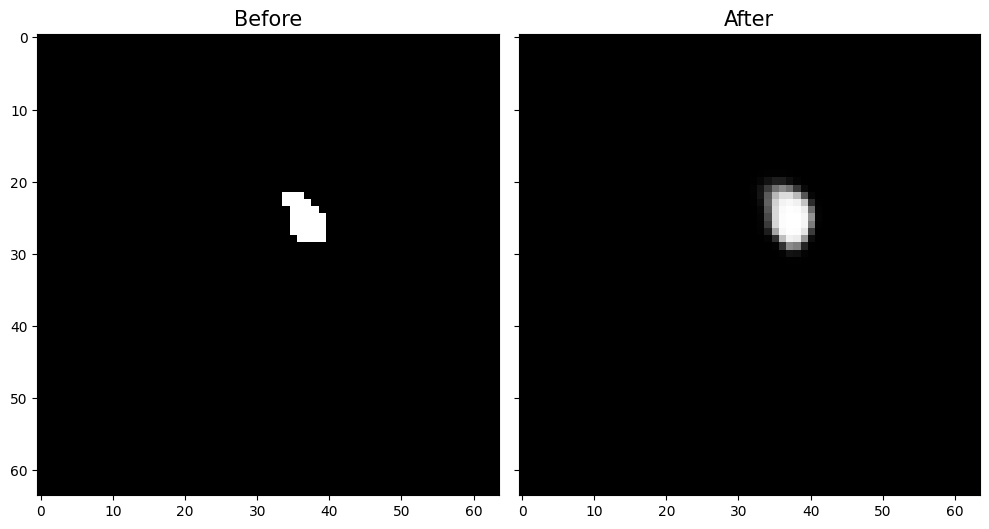

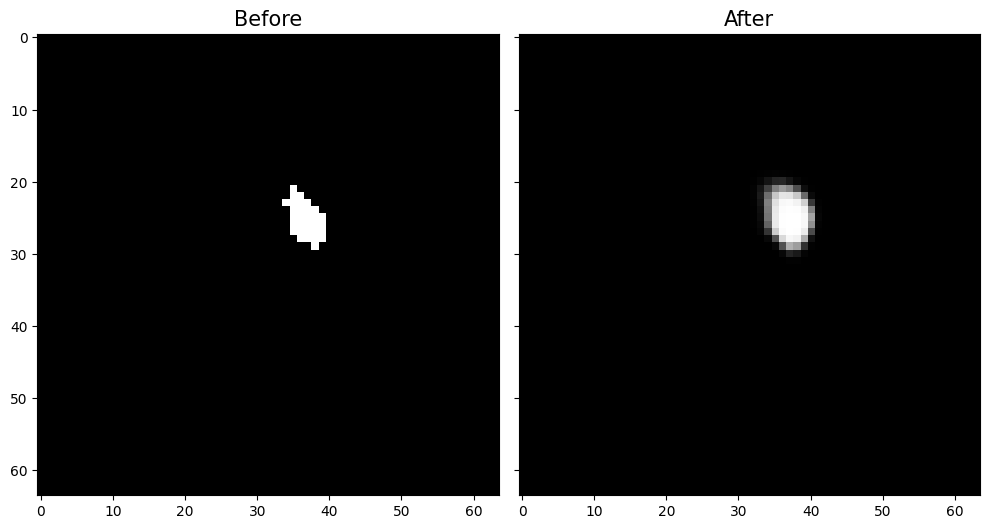

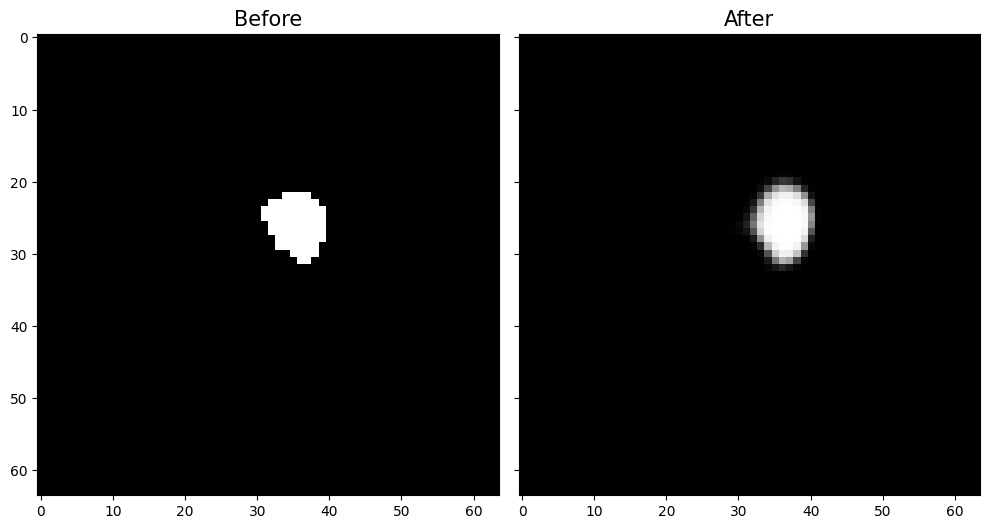

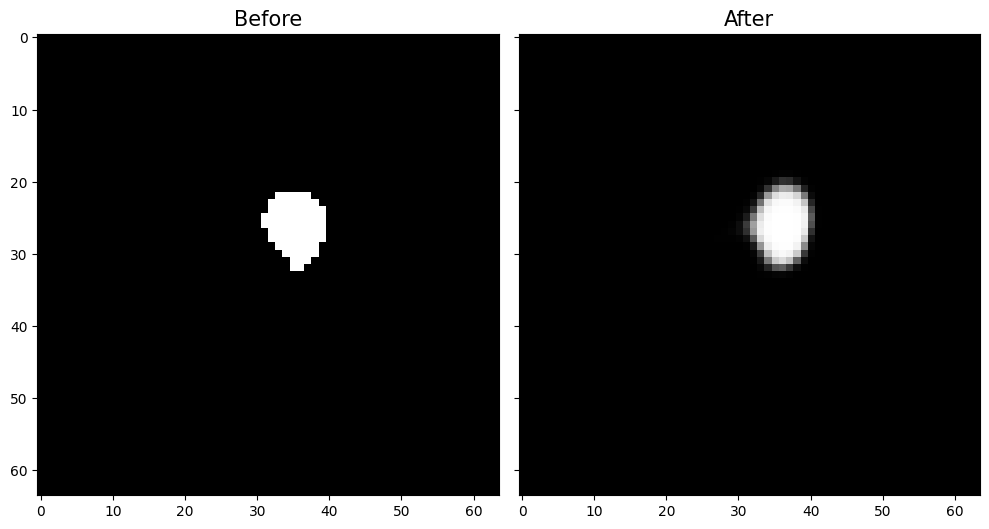

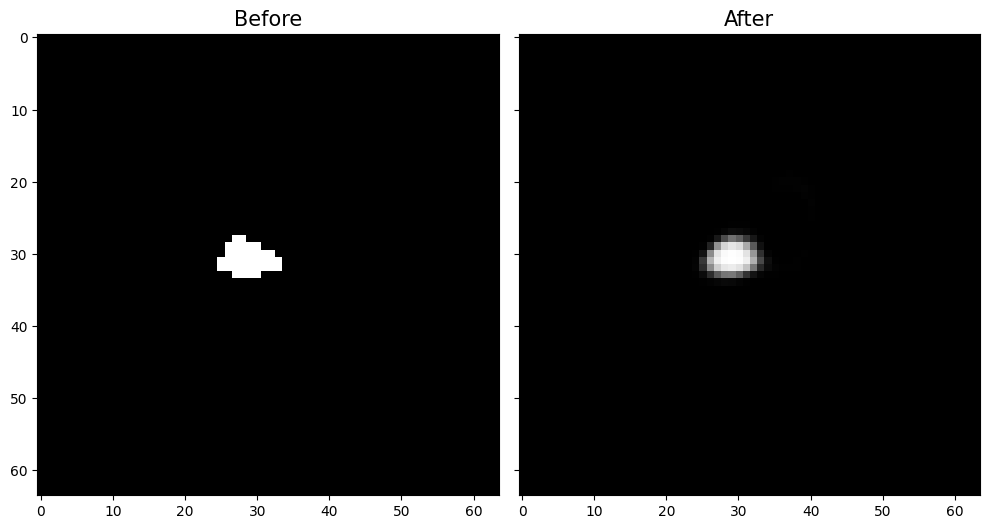

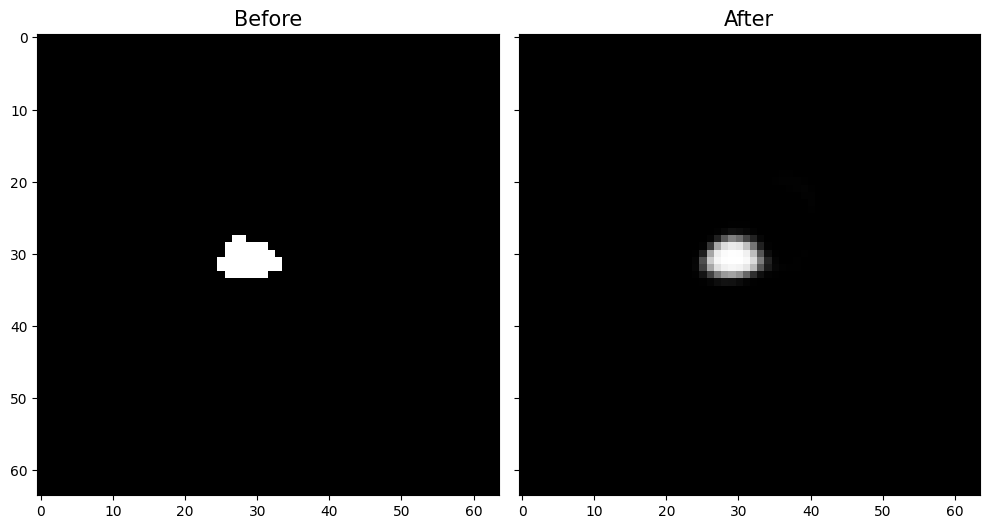

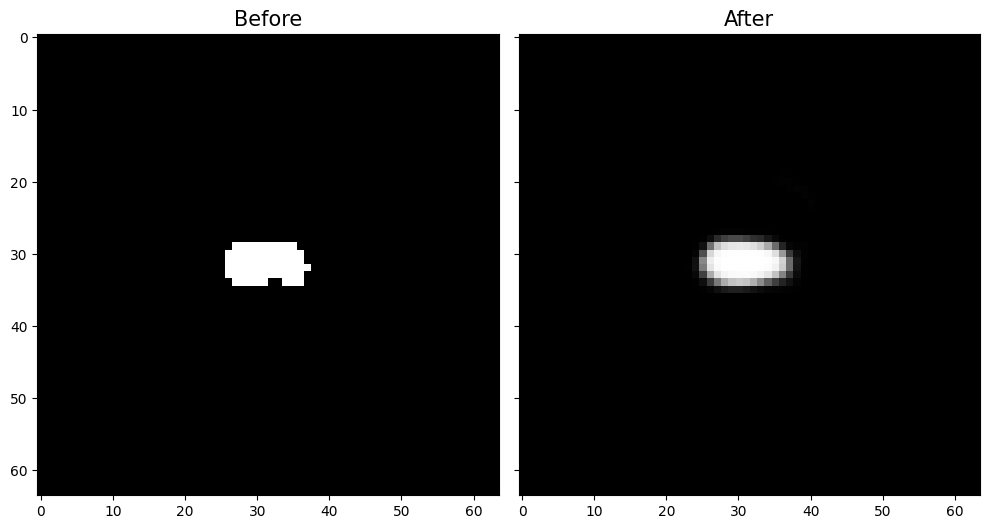

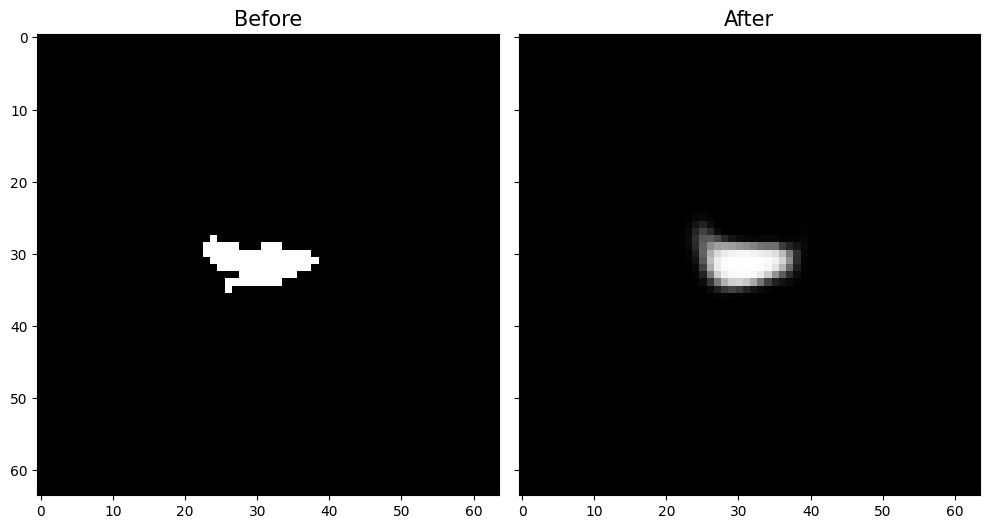

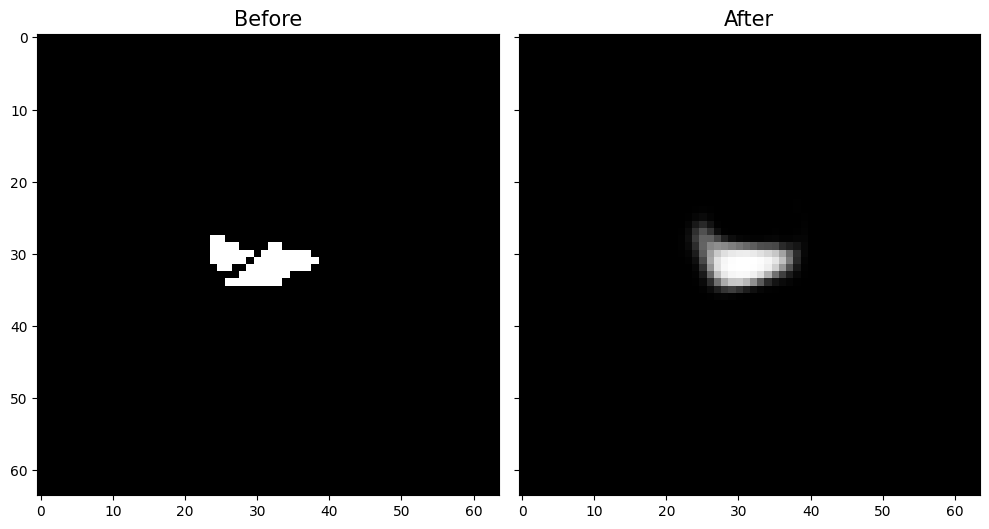

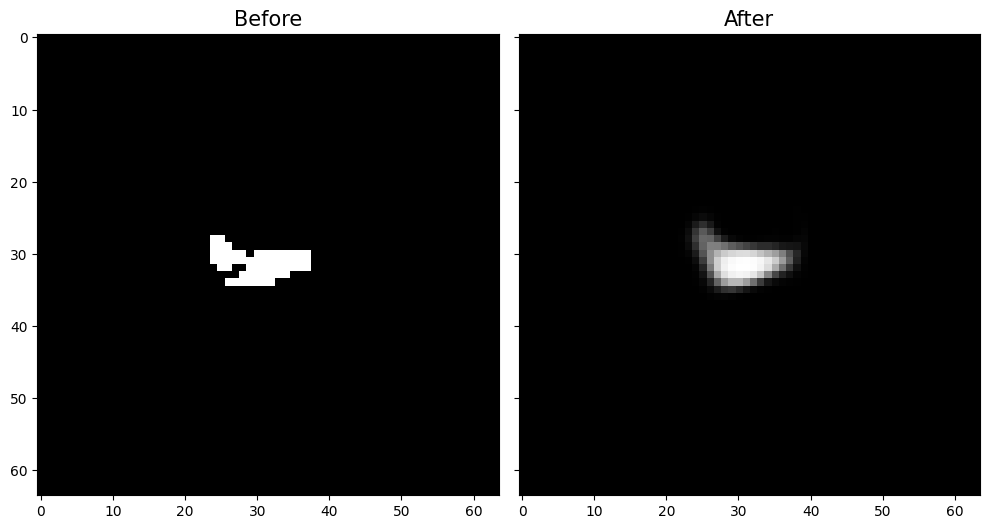

In [33]:
def one_hot_encode(mask):
    # Convert mask to integer type before one-hot encoding
    #print(f"before long {type(mask)}, {len(np.unique(mask))}, {np.unique(mask)}")
    mask_tensor = mask.long()
    #print(f"after long {type(mask_tensor)}, {len(np.unique(mask_tensor))}, {np.unique(mask_tensor)}")
    encoded_mask = torch.nn.functional.one_hot(mask_tensor)

    if encoded_mask.dim() == 5:  # Check for 5 dimensions
        encoded_mask = encoded_mask.squeeze(0)  # Remove batch dimension if present
    encoded_mask = encoded_mask.permute(3, 1, 2, 0)  # [num_channels, width, height, depth] from [depth, width, height]

    # Check if any channels are missing
    for i in range(4):
        if i not in mask_tensor.unique():
            #print(f"ADDING A CHANNEL MANUALLY {i}")
            # Create a tensor of zeros for the missing channel
            zeros = torch.zeros((1, encoded_mask.shape[1], encoded_mask.shape[2], encoded_mask.shape[3]), dtype=encoded_mask.dtype, device=encoded_mask.device)
            # Insert the zeros tensor at the correct index
            encoded_mask = torch.cat([encoded_mask[:i], zeros, encoded_mask[i:]], dim=0)

    return encoded_mask

def read_image(path):
    reader = sitk.ImageFileReader()
    reader.SetFileName(path)
    image = reader.Execute()
    return image

def castItem(image, desired_orientation='RPS'):
    # Apply the desired orientation
    image = sitk.DICOMOrient(image, desired_orientation)

    castImageFilter = sitk.CastImageFilter()
    castImageFilter.SetOutputPixelType(sitk.sitkFloat32)
    image = castImageFilter.Execute(image)
    image_array = sitk.GetArrayFromImage(image)
    if desired_orientation == 'LIA': #the LIA orientation shows [height, depth, width]
      image_array = np.transpose(image_array, (1, 0, 2))
    return image_array

model.eval()  # Set model to evaluation mode
model.to(device)  # Move model to the appropriate device
image_path = "/content/MBAS_Dataset/Training/MBAS_003/MBAS_003_gt.nii.gz"
mask_path = "/content/MBAS_Dataset/Training/MBAS_003/MBAS_003_label.nii.gz"
image = read_image(image_path)
mask = read_image(mask_path)
image = castItem(image)
mask = castItem(mask)

image = image_transform(image)
mask = mask_transform(mask)
mask = one_hot_encode(mask)

image = image.unsqueeze(0)
mask = mask.unsqueeze(0)

print(image.shape, mask.shape)
with torch.no_grad():  # Disable gradient calculation
    mask = mask.to(device)  # Move input to the appropriate device
    image = image.to(device)  # Move input to the appropriate device
    output = model(image)  # Forward pass to get the output
    image = image.cpu().numpy()
    mask =mask.cpu().numpy()
    output =output.cpu().numpy()
    explore_4D_array_comparison(mask, output)



In [ ]:
import SimpleITK as sitk
import numpy as np
import torch
import glob2
import os

# Assuming necessary imports like model, device, image_transform are already done

def save_mask(mask, output_path, reference_image):
  # Convert the numpy array back to a SimpleITK image
  print(mask.shape, reference_image.shape )
  mask_image = sitk.GetImageFromArray(mask)
  reference_image = sitk.GetImageFromArray(reference_image)
  
  # Copy the metadata from the reference image (such as spacing, origin, direction)
  mask_image.CopyInformation(reference_image)
  
  # Save the mask image
  writer = sitk.ImageFileWriter()
  writer.SetFileName(output_path)
  writer.Execute(mask_image)

def read_image(path):
  reader = sitk.ImageFileReader()
  reader.SetFileName(path)
  image = reader.Execute()
  return image

def castItem(image, desired_orientation='RPS'):
  image = sitk.DICOMOrient(image, desired_orientation)
  castImageFilter = sitk.CastImageFilter()
  castImageFilter.SetOutputPixelType(sitk.sitkFloat32)
  image = castImageFilter.Execute(image)
  image_array = sitk.GetArrayFromImage(image)
  if desired_orientation == 'LIA':
    image_array = np.transpose(image_array, (1, 0, 2))
  return image_array

class ResizeTransform:
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, img):
        d_scale = self.output_size[0] / img.shape[0]
        h_scale = self.output_size[1] / img.shape[1]
        w_scale = self.output_size[2] / img.shape[2]
        resized = zoom(img, (d_scale, h_scale, w_scale), order=0) if isinstance(img, np.ndarray) else zoom(img.numpy(), (d_scale, h_scale, w_scale), order=0)   # order=0 for nearest-neighbor
        resized = torch.from_numpy(resized)
        return resized

# Load model checkpoint
checkpoint_path = '/content/drive/MyDrive/3DUnetCheckPoint/checkpoint'
model = UNETModule.load_from_checkpoint('/content/drive/MyDrive/3DUnetCheckPoint/checkpoint/model-v8.ckpt', in_channels=IN_CHANNELS, num_classes=NUM_CLASSES)

model.eval()
model.to(device)

test_path = "/content/MBAS_Dataset/Validation"
output_root = "/content/drive/MyDrive/masksToSubmit"
image_paths = glob2.glob(test_path + '/*/*.nii.gz')
reverse_transform = transforms.Compose([ ResizeTransform((44, 64, 64)), Permute() ])


for image_path in image_paths:
  image_folder = os.path.dirname(image_path)
  subfolder_name = os.path.relpath(image_folder, test_path)

  output_folder = os.path.join(output_root, subfolder_name)
  os.makedirs(output_folder, exist_ok=True)  

  output_path = os.path.join(output_folder, os.path.basename(image_path).replace('.nii.gz', '_pred_mask.nii.gz'))

  image = read_image(image_path)
  image_array = castItem(image)

  image_t = image_transform(image_array)

  image_t = image_t.unsqueeze(0)

  with torch.no_grad():  
      image_t = image_t.to(device)  
      output = model(image_t)  
      output = output.cpu().numpy()  

      output = np.argmax(output, axis=1)[0]  

      output = output.astype(np.uint8)  

      reversed_out = np.transpose(output, (2, 1, 0))

      reversed_out = ResizeTransform((image_array.shape[0], image_array.shape[1], image_array.shape[2]))(reversed_out)
      
      save_mask(reversed_out, output_path, image_array)
